# Tuning Logistic Regression

## Import libraries

In [1]:
# Data and Numbers
import pandas as pd
import numpy as np
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve, f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import Image
from sklearn.tree import export_graphviz
%matplotlib inline

## Read in cleaned csv

In [2]:
df = pd.read_csv('online_shoppers_intention_cleaned.csv')

In [3]:
df.head()

,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Aug,Dec,Feb,Jul,...,Mar,May,Nov,Oct,Sep,New_Visitor,Returning_Visitor,Avg_Administrative,Avg_Informational,Avg_ProductRelated
0,0.20,0.20,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
1,0.00,0.10,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,32.000000
2,0.20,0.20,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
3,0.05,0.14,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,1.333333
4,0.02,0.05,0.0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,62.750000


In [4]:
df.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Revenue', 'Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'New_Visitor', 'Returning_Visitor', 'Avg_Administrative',
       'Avg_Informational', 'Avg_ProductRelated'],
      dtype='object')

## Train/test, split & Standardize the Data

In [7]:
# Let's start with all features in the dataset
X = df.drop('Revenue', axis=1)
y = df['Revenue'].values

In [8]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [13]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

-----------

## 1. Feature Selection

#### Correlations of features to "Revenue"

<AxesSubplot:>

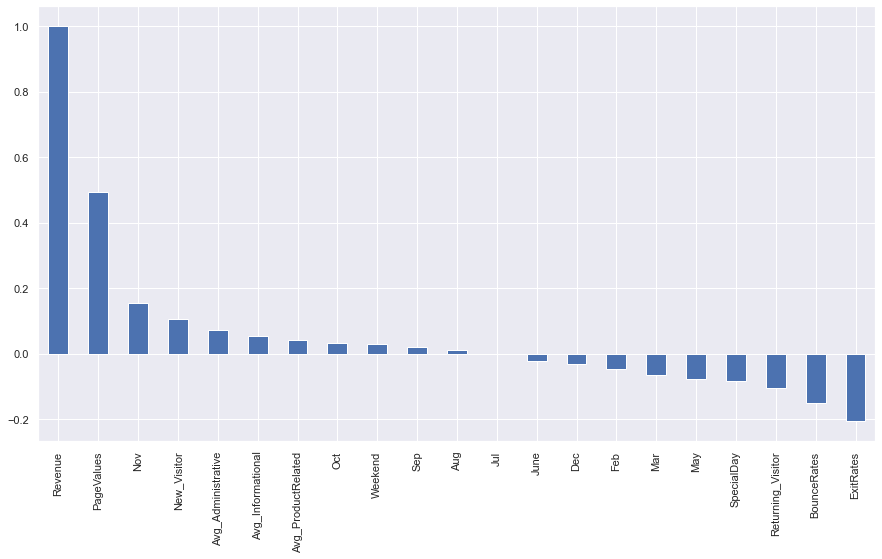

In [9]:
plt.figure(figsize=(15,8))
df.corr()['Revenue'].sort_values(ascending = False).plot(kind='bar')

#### Feature importance from random forest model trained on all features

| feature |	importance |
| --- | --- |
| PageValues |	0.586638 |
| ExitRates	|0.094965|
|BounceRates	|0.068109|
|	Avg_ProductRelated	|0.065634|
|	Avg_Administrative	|0.061952|
|	Avg_Informational	|0.032723|
|	Nov	|0.024669|
|	New_Visitor	|0.010788|
|	Returning_Visitor|	0.010628|
|	Weekend	|0.007321|
|May	|0.006636|
|	Mar|	0.005585|
|SpecialDay	|0.004925|
|	Sep	|0.004549|
|	Dec	|0.004171|
|Oct	|0.003349|
|Jul	|0.003084|
|Aug	|0.002324|
|	June|	0.001281|
|Feb	|0.000669|

### Experiment with regularization on logreg model with all features to evaluate feature importance and collinearity

Try running a model with high regularization to see which coefficients go to zero

In [18]:
# Instantiate model with low C (high regularization)
logreg = LogisticRegression(solver='saga',
                            C=0.1,
                            penalty='elasticnet',
                            l1_ratio=0.95)

# Fit model to the standardized training data
logreg.fit(X_train_scaled, y_train)

/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=0.1, l1_ratio=0.95, penalty='elasticnet', solver='saga')

In [19]:
# Look at coefficients
logreg_coefs = pd.DataFrame(sorted(list(zip(X.columns, logreg.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])
logreg_coefs

,Feature,Coefficient
0,PageValues,1.500817
1,Nov,0.323218
2,Avg_Informational,0.055876
3,Sep,0.052957
4,Aug,0.045934
5,Weekend,0.042939
6,Avg_Administrative,0.040311
7,Oct,0.039984
8,Avg_ProductRelated,0.036796
9,New_Visitor,0.036698


We can see that coefficients for June and Returning_Visitor went to 0 so we will not use those features moving forward.

### Initial Logreg model on all features except for June and Returning_Visitor

In [20]:
# New feature dataframe without June and Returning Visitor
X = df.drop(['June', 'Returning_Visitor', 'Revenue'], axis=1)

# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Standardize the data
scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

In [21]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear')

# Fit model to the training data
logreg.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

In [22]:
# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(logreg, X_train_scaled, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.04890609 0.0362761  0.02547097 0.02734399 0.02618814]
Average score: 0.03283705711364746
 
Metric: score_time
Scores: [0.00981593 0.00449395 0.00376606 0.004426   0.00379014]
Average score: 0.005258417129516602
 
Metric: test_LogLoss
Scores: [4.00882503 3.65870788 3.93879609 4.30642705 3.85322657]
Average score: 3.9531965230545594
 
Metric: test_ROC AUC
Scores: [0.67817353 0.70158332 0.66463714 0.66740966 0.69292043]
Average score: 0.6809448161266276
 


### Now let's try to reduce features even more. Use subset considering random forest feature importance and feature correlations to "Revenue"

**Subset 1:**

Let's pick and try: PageValues, ExitRates, Avg_ProductRelated, Avg_Informational, Avg_Administrative, Nov, New_Visitor, Weekend, May, Mar, SpecialDay

In [23]:
X1 = df[['PageValues', 'ExitRates', 'Avg_ProductRelated', 'Avg_Informational', 'Avg_Administrative', 'Nov', 'New_Visitor', 'Weekend', 'May', 'Mar', 'SpecialDay']]

# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have similar proportions of either target class
X1_train, X1_test, y_train, y_test = train_test_split(X1,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Standardize the data
scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X1_train_scaled = pd.DataFrame(scaler.fit_transform(X1_train.values),
                              columns=X1.columns)

# Scale the test data
X1_test_scaled = pd.DataFrame(scaler.transform(X1_test.values),
                             columns=X1.columns)

In [24]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear')

# Fit model to the training data
logreg.fit(X1_train_scaled, y_train)

LogisticRegression(solver='liblinear')

In [25]:
# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(logreg, X1_train_scaled, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.02502608 0.02420688 0.0213089  0.01469898 0.01624703]
Average score: 0.02029757499694824
 
Metric: score_time
Scores: [0.00653505 0.00675416 0.00387001 0.00404406 0.00384617]
Average score: 0.005009889602661133
 
Metric: test_LogLoss
Scores: [4.02633074 3.65870869 3.88627935 4.30642624 3.74813699]
Average score: 3.9251764015004453
 
Metric: test_ROC AUC
Scores: [0.67653418 0.70426249 0.67089476 0.66474156 0.69605948]
Average score: 0.6824984943718286
 


The CV LogLoss improved and the ROC AUC improved marginally.

--------------------------

## 2. Handle Class Imbalance

In [26]:
# Inspect target distribution
df['Revenue'].value_counts(normalize=True)

0    0.845255
1    0.154745
Name: Revenue, dtype: float64

### Try different class weights

#### a. Balanced

In [27]:
# Instantiate
logreg = LogisticRegression(class_weight='balanced', solver='liblinear')

# Fit
logreg.fit(X1_train_scaled, y_train)

# Score
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(logreg, X1_train_scaled, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.02620625 0.02593708 0.01793504 0.01620007 0.01583791]
Average score: 0.020423269271850585
 
Metric: score_time
Scores: [0.00456285 0.00717187 0.00395918 0.00405717 0.00368214]
Average score: 0.0046866416931152345
 
Metric: test_LogLoss
Scores: [4.65659445 5.28682492 5.12926822 5.23429765 5.51719152]
Average score: 5.164835349899091
 
Metric: test_ROC AUC
Scores: [0.80907831 0.83177655 0.82911605 0.80359418 0.79702715]
Average score: 0.814118448717981
 


ROC AUC is better by a lot, but LogLoss is worse.

#### b. Try Positive Class Weights from 1 to 9

In [30]:
for i in range(1,10):
    # Instantiate
    logreg = LogisticRegression(class_weight={1 : i, 0 : 1}, solver='liblinear')
    
    # Fit
    logreg.fit(X1_train_scaled, y_train)

    # Score
    scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}
    results = cross_validate(logreg, X1_train_scaled, y_train, cv=5, scoring=scoring)
    
    print("Positive class weight:", i)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print("Metric:", metric_name)
        print("Scores:", results[metric_name])
        print("Average score:", average_score)
        print(" ")
    print(" ")

Positive class weight: 1
Metric: fit_time
Scores: [0.02705312 0.01777315 0.01655293 0.01429892 0.01605225]
Average score: 0.018346071243286133
 
Metric: score_time
Scores: [0.00499368 0.0036509  0.0038259  0.00371909 0.00363684]
Average score: 0.0039652824401855465
 
Metric: test_LogLoss
Scores: [4.02633074 3.65870869 3.88627935 4.30642624 3.74813699]
Average score: 3.9251764015004453
 
Metric: test_ROC AUC
Scores: [0.67653418 0.70426249 0.67089476 0.66474156 0.69605948]
Average score: 0.6824984943718286
 
 
Positive class weight: 2
Metric: fit_time
Scores: [0.01543188 0.01601911 0.01404285 0.01610899 0.01430726]
Average score: 0.015182018280029297
 
Metric: score_time
Scores: [0.00369    0.00370002 0.00393796 0.00381207 0.00400186]
Average score: 0.0038283824920654296
 
Metric: test_LogLoss
Scores: [3.74624862 3.34361433 3.4661519  4.11387877 3.57300241]
Average score: 3.648579207003344
 
Metric: test_ROC AUC
Scores: [0.73357412 0.76190195 0.74238904 0.7334092  0.74995624]
Average sco

As the positive class weight goes up, the ROC AUC keeps getting better until positive class weight 8. However, the logloss gets worse. We want to balance these 2 metrics. A higher AUC ROC means the order of the predictions is becoming more correct. However, as LogLoss gets worse, that means there are more confident false predictions.

- The positive class weight with the best LogLoss, 3.648, is weight 2.
- The positive weight class with the best ROC AUC, 0.819, is weight 8. (However, the LogLoss for this weight is way too high, 6.845).

**Scores to beat**

As a reference:
- the balanced weights gave LogLoss 5.165 and ROC AUC 0.814.
- the prior model with class imbalance and the selected features gave **LogLoss 3.925 and ROC AUC 0.682.**



Let's rule out balanced weights since the LogLoss is worse than with class imbalance.

**Now considering the positive weight class options**

A positive class weight of 5 or above is probably too extreme anyway.

Of weights 1-4,

Weight 3 is the best option. **It decreases LogLoss to 3.670 and increases ROC AUC to 0.779.**

_________________________________________

#### WINNER! Choose Pos:Neg Class Weights 3:1

--------------------------------------------

### 3. Tune hyperparameters using GridSearchCV: Penalty and Regularization (C)

In [35]:
# Instantiate model with best class weights
logreg = LogisticRegression(class_weight={1 : 3, 0 : 1}, solver='liblinear')

In [36]:
# Try different values of C (regularization), and different penalties (l1 lasso l2 ridge)
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid={"C": C_param_range, "penalty":["l1","l2"]}

# set metric to be optimized
roc_auc = make_scorer(roc_auc_score)

In [37]:
# instantiate and fit the grid on training data with selected features
grid = GridSearchCV(logreg, param_grid, cv=10, scoring=roc_auc)
grid.fit(X1_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 1, 1: 3},
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(roc_auc_score))

In [38]:
df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019876,0.008602,0.012438,0.014907,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",0.737786,0.754126,0.760932,0.766928,0.759821,0.749953,0.728110,0.752027,0.747232,0.749633,0.750655,0.010750,14
1,0.023949,0.006795,0.006367,0.003874,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.751129,0.746332,0.773076,0.788604,0.788227,0.761004,0.752027,0.731675,0.759971,0.750500,0.760255,0.017343,13
2,0.020183,0.002389,0.004076,0.000623,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.766869,0.764800,0.783479,0.804345,0.804383,0.761604,0.754118,0.757991,0.775110,0.754635,0.772733,0.017985,11
3,0.028453,0.017042,0.004555,0.000820,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.763601,0.755266,0.788216,0.800477,0.797804,0.758007,0.750828,0.753502,0.773043,0.749900,0.769064,0.018654,12
4,0.028308,0.004746,0.005665,0.002881,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.773405,0.767739,0.796222,0.805814,0.801985,0.758007,0.752919,0.767260,0.777778,0.754035,0.775516,0.018612,10


In [39]:
# examine the best model/hyperparameters
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'C': 10, 'penalty': 'l1'}
Best estimator:  LogisticRegression(C=10, class_weight={0: 1, 1: 3}, penalty='l1',
                   solver='liblinear')
Best score:  0.7768568420678885


#### Fit and score new logistic regression model with the best hyperparameters

In [40]:
# Instantiate Model
logreg = LogisticRegression(C=10,
                            class_weight={0: 1, 1: 3},
                            penalty='l1',
                            solver='liblinear')

# Fit Model
logreg.fit(X1_train_scaled, y_train)

# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(logreg, X1_train_scaled, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.03630686 0.03629684 0.019238   0.01939487 0.02371621]
Average score: 0.026990556716918947
 
Metric: score_time
Scores: [0.02039599 0.01586819 0.00900388 0.01216412 0.00889492]
Average score: 0.013265419006347656
 
Metric: test_LogLoss
Scores: [3.58870488 3.37863832 3.44865835 4.07887666 3.85324927]
Average score: 3.6696254969658915
 
Metric: test_ROC AUC
Scores: [0.77378032 0.80015037 0.78421591 0.76736025 0.76792707]
Average score: 0.7786867842478531
 


**Comparing to previous best-performing model**

Now let's compare LogLoss and ROC AUC scores to the model we had prior to tuning hyperparameters (a.k.a. model after selecting best feature subset and class weights)

For reference, here were the scores to the previous best-performing model that we're looking to beat:

Positive class weight: 3
 
Metric: test_LogLoss
- Scores: [3.58870488 3.37863832 3.44865835 4.07887666 3.85324927]
- Average score: 3.6696254969658915
 
Metric: test_ROC AUC
- Scores: [0.77378032 0.80015037 0.78421591 0.76736025 0.76792707]
- Average score: 0.7786867842478531

As we can see, the scores did not change at all after tuning the regularization C parameter and the penalty parameter. After all, logistic regression is already optimized for logloss.

------------------

### 4. Look at feature importance for any coefs close to 0

In [43]:
logreg_coefs = pd.DataFrame(sorted(list(zip(X1.columns,
                                              logreg.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])

In [44]:
logreg_coefs

,Feature,Coefficient
0,PageValues,2.000522
1,Nov,0.346616
2,Avg_Informational,0.080833
3,Avg_Administrative,0.062946
4,Weekend,0.050037
5,Avg_ProductRelated,0.020976
6,New_Visitor,0.019583
7,SpecialDay,-0.065482
8,Mar,-0.173121
9,May,-0.245609


None of the features have a really low importance close to 0 relative to the others. Let's keep them all.

-----------

### 5. Score final model on test data

In [47]:
# Instantiate Model
final_logreg = LogisticRegression(C=10,
                            class_weight={0: 1, 1: 3},
                            penalty='l1',
                            solver='liblinear')

# Fit Model
final_logreg.fit(X1_train_scaled, y_train)

LogisticRegression(C=10, class_weight={0: 1, 1: 3}, penalty='l1',
                   solver='liblinear')

In [49]:
# Calculate area under the curve (AUC) for ROC and LogLoss on test data
roc_auc_test = roc_auc_score(y_test,
                           final_logreg.predict_proba(X1_test)[:, 1])

roc_auc_test

0.8646267749294048

In [51]:
log_loss_test = log_loss(y_test,
                           final_logreg.predict_proba(X1_test)[:, 1])

In [52]:
log_loss_test

3.8956815386948835

#### Look at distribution of predicted probabilities

(array([234., 321., 245., 180., 144., 121., 102.,  99., 132., 888.]),
 array([0.15102201, 0.23591981, 0.32081761, 0.4057154 , 0.4906132 ,
        0.575511  , 0.6604088 , 0.7453066 , 0.8302044 , 0.9151022 ,
        1.        ]),
 <BarContainer object of 10 artists>)

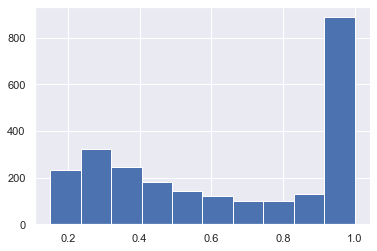

In [53]:
plt.hist(final_logreg.predict_proba(X1_test)[:, 1])

(array([118., 116., 173., 148., 138., 107., 100.,  80.,  71.,  73.,  66.,
         55.,  55.,  47.,  50.,  49.,  53.,  79.,  67., 821.]),
 array([0.15102201, 0.19347091, 0.23591981, 0.27836871, 0.32081761,
        0.36326651, 0.4057154 , 0.4481643 , 0.4906132 , 0.5330621 ,
        0.575511  , 0.6179599 , 0.6604088 , 0.7028577 , 0.7453066 ,
        0.7877555 , 0.8302044 , 0.8726533 , 0.9151022 , 0.9575511 ,
        1.        ]),
 <BarContainer object of 20 artists>)

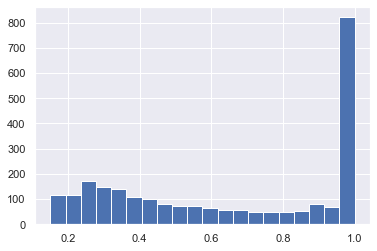

In [54]:
# Now plot with more bins
plt.hist(final_logreg.predict_proba(X1_test)[:, 1], bins=20)

In [55]:
X1_test.shape

(2466, 11)

Looks like of the 2466 observations in the test set, 800 were assigned a very high probability of being the positive class.

In [56]:
800/2466

0.32441200324412

In the entire data set, ~15% of samples are in the positive class

In [58]:
y_test

array([0, 0, 1, ..., 0, 0, 0])

In [60]:
sum(y_test) / len(y_test)

0.1549067315490673

In the test set as well, ~15% of observations were in the positive class.

This means that the model is incorrectly predicting an extra 15% of observations to be in the positive class.

----------------------

### 6. Look at coefficients from final model

In [62]:
final_logreg_coefs = pd.DataFrame(sorted(list(zip(X1.columns,
                                              final_logreg.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])

In [63]:
final_logreg_coefs

,Feature,Coefficient
0,PageValues,2.000529
1,Nov,0.346612
2,Avg_Informational,0.080831
3,Avg_Administrative,0.062948
4,Weekend,0.050036
5,Avg_ProductRelated,0.020977
6,New_Visitor,0.019586
7,SpecialDay,-0.065482
8,Mar,-0.173122
9,May,-0.245604


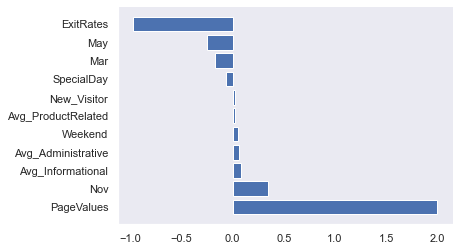

In [64]:
# Plot coefficients
plt.barh(final_logreg_coefs['Feature'], width=final_logreg_coefs['Coefficient'])
plt.grid(b=False)
sns.despine()

#### Interpret coefficients in terms of odds

##### convert intercept log-odds to probability
logodds = final_logreg_coefs.intercept_

odds = np.exp(logodds)

prob = odds / (1 + odds)

prob[0]

In [66]:
final_logreg_coefs['Odds'] = np.exp(final_logreg_coefs.Coefficient)

In [67]:
final_logreg_coefs

,Feature,Coefficient,Odds
0,PageValues,2.000529,7.392967
1,Nov,0.346612,1.414267
2,Avg_Informational,0.080831,1.084188
3,Avg_Administrative,0.062948,1.064971
4,Weekend,0.050036,1.051309
5,Avg_ProductRelated,0.020977,1.021199
6,New_Visitor,0.019586,1.019779
7,SpecialDay,-0.065482,0.936616
8,Mar,-0.173122,0.841035
9,May,-0.245604,0.782232


--------------------

### Future Work: Deploy into app using Streamlit

In [68]:
# saving the model 
# import pickle 
# pickle_out = open("classifier.pkl", mode = "wb") 
# pickle.dump(final_logreg, pickle_out) 
# pickle_out.close()

In [69]:
# !pip install -q pyngrok

# !pip install -q streamlit

# !pip install -q streamlit_ace